# Two-View Geometry



## Import Modules

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## Load Image and Feature Points

We load two images and the matched keypoints. They are visualized as follows.


(-0.5, 1535.5, 1023.5, -0.5)

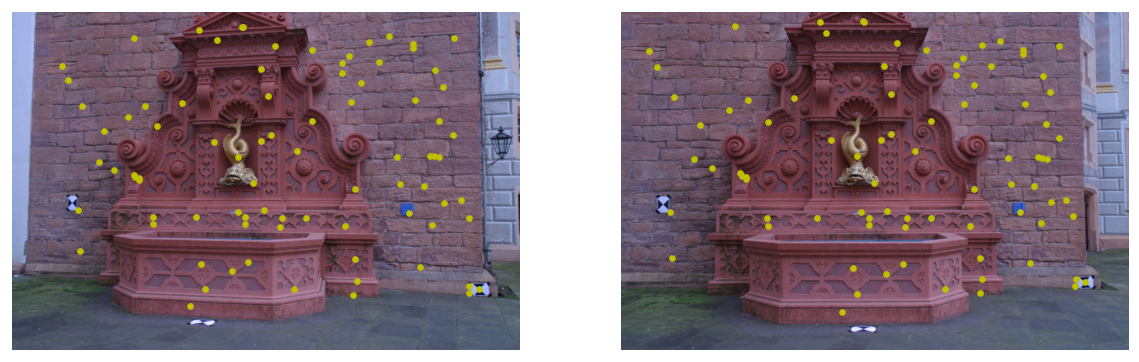

In [3]:
# load images
img1 = cv2.imread('data/0001.jpg')
img2 = cv2.imread('data/0002.jpg')

# load intrinsic paramters
K = np.array([[1379.74, 0, 760.35],[0, 1382.08, 503.41], [0,0,1]])
K1 = K
K2 = K

# load matches keypoints 
p1 = np.loadtxt('data/matches0001.txt')
p2 = np.loadtxt('data/matches0002.txt')
n = p1.shape[1]
# extend to homogeneous cooridinates
p1 = np.concatenate( (p1, np.ones((1,n))), axis=0 )
p2 = np.concatenate( (p2, np.ones((1,n))), axis=0 )

# visualization
fig, axes = plt.subplots(1, 2, dpi=120, figsize=(12,6))
axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0].plot(p1[0,:],p1[1,:],'y.')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[1].plot(p2[0,:],p2[1,:],'y.')
axes[1].axis('off')

## Eight-Point Algorithm

1. First, pixel coordinates are normalized by left-multiplying $K^{-1}$

2. Each row of $Q$ is given by $(\bar p_1^i \otimes \bar p_2^i)^T$. 

3. Decompose $Q = US V^T$, and $\mathrm{vec}(E)$ corresponds to the last column of $V$, which is reshaped into a 3 by 3 matrix $E$

In [4]:
p_bar_1 = scipy.linalg.inv(K1)@p1
p_bar_2 = scipy.linalg.inv(K1)@p2

Q = np.zeros((n,9))
for i in range(n):
    Q[i,:] = np.kron(p_bar_1[:,i], p_bar_2[:,i]).T

U, S, VT = scipy.linalg.svd(Q)


E = VT[-1,:]
print(E)
E = E.reshape(3,3).T
print(E)



[-2.32658231e-04  1.61584860e-01 -1.94754336e-03 -2.30066653e-02
  1.70952962e-03 -7.04422370e-01 -1.38566261e-03  6.90754078e-01
  5.14852933e-04]
[[-2.32658231e-04 -2.30066653e-02 -1.38566261e-03]
 [ 1.61584860e-01  1.70952962e-03  6.90754078e-01]
 [-1.94754336e-03 -7.04422370e-01  5.14852933e-04]]


## Triangulation

See the notes for Stereo Vison. Let the perspective projection matrix be $M_1 = [I_{3\times3}|0]$ and $M_2 = [R|T]$. The homogeneous coordinates of the 3D point $P^i$ belongs to the null space of
\begin{align*}
null \begin{bmatrix} \hat p^i_1 M_1 \\ \hat p^i_2 M_2 \end{bmatrix}_{6\times 4}
\end{align*}

In [5]:
def triangulation(p1, p2, M1, M2):
    # Input
    # p1, p2: 3 by n pixel homogeneous coordinates
    # M1, M2, 3 by 4 perspective projection matrix
    # Output
    # P: 3 by n (nonhomogeneous) world coordinate
    assert(p1.shape[0]==3 and p2.shape[0]==3 and p1.shape[1]==p2.shape[1] )
    
    n=p1.shape[1]
    P = np.zeros((3,n))
    for i in range(n):
        Q = np.concatenate(( mae6292.hat(p1[:,i])@M1, mae6292.hat(p2[:,i])@M2), axis=0)
        U, S, VT = scipy.linalg.svd(Q)
        Pi = VT[-1,:]
        P[:,i] = Pi[0:3]/Pi[3]
    
    return P


Verify the above function with random data. We did not use any special structure of $M_1$ and $M_2$ in the above expression, and they can be generated randomly.

In [6]:
n = 10
P_test = np.random.rand(4,n)
M1_test = np.random.rand(3,4)
M2_test = np.random.rand(3,4)
p1_test = M1_test@P_test
p2_test = M2_test@P_test

P_test_new = triangulation( p1_test, p2_test, M1_test, M2_test)

print(scipy.linalg.norm(P_test[0:3,:]/P_test[3,:]-P_test_new))

1.3694250367918085e-14


## Extract $(R,T)$

In [7]:
U, S, VT = scipy.linalg.svd(E)

R = np.zeros((3,3,4))
T = np.zeros((3,4))
W = np.array( [[0,1,0], [-1,0,0], [0,0,1]])

R[:,:,0], T[:,0] = U@W@VT, U[:,2]
R[:,:,1], T[:,1] = U@W@VT, -U[:,2]
R[:,:,2], T[:,2] = U@W.T@VT, U[:,2]
R[:,:,3], T[:,3] = U@W.T@VT, -U[:,2]

for i in range(4):
    if scipy.linalg.det(R[:,:,i]) < 0:
        R[:,:,i] = -R[:,:,i]


In [8]:
M1 = K1@np.concatenate( (np.identity(3), np.zeros((3,1))), axis=1 )

N_negative_depth = np.zeros(4)
for i in range(4):
    M2 = K2@np.concatenate( (R[:,:,i], T[:,i].reshape(-1,1)), axis=1 )
    P = triangulation( p1, p2, M1, M2)
    N_negative_depth[i] = len(np.where(P[2,:]<0)[0])
    
print(N_negative_depth)



[84.  0. 48. 36.]


In [9]:
i_opt = np.argmin(N_negative_depth)
R=R[:,:,i_opt]
T=T[:,i_opt].reshape(-1,1)


In [10]:
M2 = K2@np.concatenate( (R, T.reshape(-1,1)), axis=1 )
P = triangulation( p1, p2, M1, M2)
print(T)


[[ 0.9994653 ]
 [ 0.00197824]
 [-0.03263744]]


In [11]:
importlib.reload(mae6292)

R, T = mae6292.essentialmatrix2RT(E, p1, p2, K1, K2)
E, R, T = mae6292.eightpoint_algorithm(p1, p2, K1, K2)
print(R,T)

[[ 0.98061954 -0.00478728 -0.1958632 ]
 [ 0.00442538  0.9999876  -0.00228531]
 [ 0.19587171  0.00137425  0.98062857]] [[ 0.9994653 ]
 [ 0.00197824]
 [-0.03263744]]


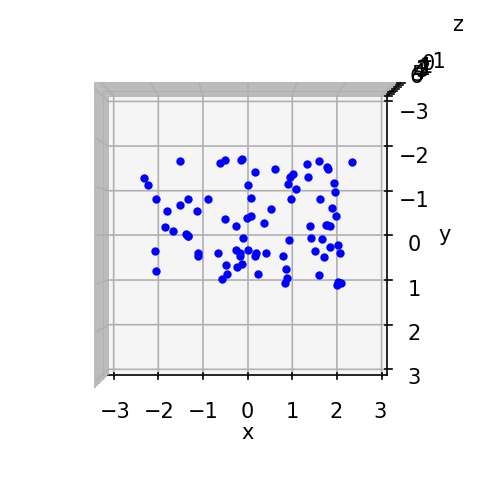

In [23]:
#%matplotlib notebook
# %matplotlib inline
fig = plt.figure(dpi=150)
# ax = fig.gca(projection='3d') # depreciated
ax = fig.add_subplot(projection='3d')

ax.plot(P[0,:],P[1,:],P[2,:],'b.')
ax.axes.set_xlim3d(-3,3)
ax.axes.set_ylim3d(-3,3) 
ax.axes.set_zlim3d(-1,6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(-90,-90) # front view


#mae6292.draw_frame(ax, R,T)
#mae6292.draw_frame(ax, np.identity(3), np.zeros((3,1)) )
